In [5]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import utils
import numpy as np
import random
from PIL import Image
import torch
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
%matplotlib inline

In [12]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text is not None:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

class AverageCalculator:
    def __init__(self):
        self.reset()

    def update(self, num):
        self.count += 1
        self.sum += num

    def average(self):
        return self.sum/self.count

    def reset(self):
        self.sum = self.count = 0.0

In [13]:
class Config():
    training_dir = "data/faces/training"
    testing_dir = "data/faces/testing"
    train_batch_size = 64
    train_number_epochs = 500

In [14]:
class FaceMatcherDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [15]:
folder_dataset = datasets.ImageFolder(root=Config.training_dir)


In [16]:
siamese_dataset = FaceMatcherDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

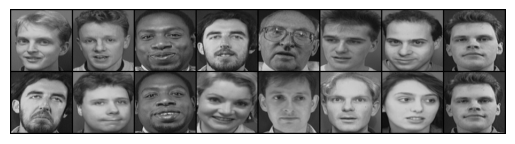

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [17]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


In [18]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [19]:

class FaceMatcher(nn.Module):
            def __init__(self):
                super().__init__()
                self.cnns = nn.Sequential(
                    nn.Conv2d(1, 4, padding=1, stride=2, kernel_size=3),
                    nn.LeakyReLU(0.2),
                    nn.BatchNorm2d(4),

                    nn.Conv2d(4, 8, padding=1, stride=2, kernel_size=3),
                    nn.LeakyReLU(0.2),
                    nn.BatchNorm2d(8),


                    nn.Conv2d(8, 16, padding=1, stride=2, kernel_size=3),
                    nn.LeakyReLU(0.2),
                    nn.BatchNorm2d(16),
                )

                self.fc = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(16*13**2, 500),
                    nn.LeakyReLU(0.2),

                    nn.Linear(500, 100),
                    nn.LeakyReLU(0.2),

                    nn.Linear(100, 5)
                )

                self.criterion = ContrastiveLoss()
                self.optimizer = optim.Adam(self.parameters(), lr = 0.0005 )

            def check_output_sizes(self, input_size: tuple[int, ...]):
                x = torch.zeros(*input_size)
                print("Input ->", input_size, "\n")
                with torch.no_grad():
                    self.eval()
                    for layer in self.cnns.children():
                        x = layer(x)
                        print(f"{layer.__class__.__name__} -> {tuple(x.shape)}\n")

                    for layer in self.fc.children():
                        x = layer(x)
                        print(f"{layer.__class__.__name__} -> {tuple(x.shape)}\n")
                    self.train()

            def get_face_code(self, x):
                output = self.cnns(x)
                output = output.view(output.size()[0], -1)
                output = self.fc(output)
                return output

            def forward(self, input1, input2):
                output1 = self.get_face_code(input1)
                output2 = self.get_face_code(input2)
                return output1, output2

            def optimize(self, input1, input2, label):
                self.optimizer.zero_grad()
                output1, output2 = self(input1, input2)
                loss = self.criterion(output1, output2, label)
                loss.backward()
                self.optimizer.step()
                return loss

In [20]:
model = FaceMatcher()
model.check_output_sizes((1,1,100,100))

Input -> (1, 1, 100, 100) 

Conv2d -> (1, 4, 50, 50)

LeakyReLU -> (1, 4, 50, 50)

BatchNorm2d -> (1, 4, 50, 50)

Conv2d -> (1, 8, 25, 25)

LeakyReLU -> (1, 8, 25, 25)

BatchNorm2d -> (1, 8, 25, 25)

Conv2d -> (1, 16, 13, 13)

LeakyReLU -> (1, 16, 13, 13)

BatchNorm2d -> (1, 16, 13, 13)

Flatten -> (1, 2704)

Linear -> (1, 500)

LeakyReLU -> (1, 500)

Linear -> (1, 100)

LeakyReLU -> (1, 100)

Linear -> (1, 5)



In [21]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=Config.train_batch_size)


In [24]:
net = FaceMatcher()

In [23]:
import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.2.2+cpu
Is CUDA enabled? False


In [25]:
loss_history = []
calc = AverageCalculator()

for epoch in tqdm(range(Config.train_number_epochs)):
    calc.reset()
    for i, data in enumerate(train_dataloader):
        img0, img1 , label = data
        img0, img1 , label = img0, img1 , label
        loss = net.optimize(img0, img1, label)
        calc.update(loss.item())

    loss_history.append(calc.average())

plt.plot(loss_history)
plt.show()
print("Final Loss =", loss_history[-1])

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(net.state_dict(), "FaceCompare.pt")


In [ ]:
folder_dataset_test = datasets.ImageFolder(root=Config.testing_dir)
siamese_dataset = FaceMatcherDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,batch_size=1)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))